# Recommend System

Data : [MovieLens Latest Datasets](https://grouplens.org/datasets/movielens/latest/)

# Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import itertools

import os
import time
import math

# torch tools
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# visualization tools
from matplotlib import pyplot as plt, style
style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from tqdm import tqdm

# warning control tool
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

# Load Data & Data preprocessing

## Movies

**Info**

- `Action`
- `Adventure`
- `Animation`
- `Children`
- `Comedy`
- `Crime`
- `Documentary`
- `Drama`
- `Fantasy`
- `Film-Noir`
- `Horror`
- `Musical`
- `Mystery`
- `Romance`
- `Sci-Fi`
- `Thriller`
- `War`
- `Western`
- (no genres listed)

In [3]:
movies = pd.read_csv('/content/drive/MyDrive/ToBigs/RS/ml-latest-small 2/movies.csv')

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


**Movie genres 종류 확인하기**

In [5]:
movies['genres'].value_counts()

Drama                                                  1053
Comedy                                                  946
Comedy|Drama                                            435
Comedy|Romance                                          363
Drama|Romance                                           349
                                                       ... 
Action|Crime|Horror|Mystery|Thriller                      1
Adventure|Animation|Children|Comedy|Musical|Romance       1
Action|Adventure|Animation|Comedy|Crime|Mystery           1
Children|Comedy|Fantasy|Sci-Fi                            1
Action|Animation|Comedy|Fantasy                           1
Name: genres, Length: 951, dtype: int64

In [6]:
# list of genre
genre_dict = {}

for row in movies['genres'] : 
    parsed_genre = row.split("|")
    for genre_name in parsed_genre : 
        if (genre_name in genre_dict) == False :
        	genre_dict[genre_name] = 1
        else :
        	genre_dict[genre_name] = genre_dict[genre_name] + 1
                       
genre_dict

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

In [232]:
# DataFrame of genres
df_genres = pd.DataFrame(columns=genre_dict, index=movies.index)

df_genres.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [233]:
Fct = 0
for i, row in df_genres.iterrows():
    movie_id = row.name
    list_of_genres = movies.loc[movie_id]['genres'].split('|')
    
    df_genres.loc[movie_id][list_of_genres] = 1

In [234]:
df_genres = df_genres.fillna(0)
df_genres['num_genres'] = df_genres.sum(axis=1)

print(df_genres.shape)
print(df_genres)

(9742, 21)
      Adventure  Animation  Children  Comedy  Fantasy  Romance  Drama  Action  \
0             1          1         1       1        1        0      0       0   
1             1          0         1       0        1        0      0       0   
2             0          0         0       1        0        1      0       0   
3             0          0         0       1        0        1      1       0   
4             0          0         0       1        0        0      0       0   
...         ...        ...       ...     ...      ...      ...    ...     ...   
9737          0          1         0       1        1        0      0       1   
9738          0          1         0       1        1        0      0       0   
9739          0          0         0       0        0        0      1       0   
9740          0          1         0       0        0        0      0       1   
9741          0          0         0       1        0        0      0       0   

      Crime  Thr

In [235]:
df_genres = movies['genres'].str.get_dummies(sep='|')

df_genres.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**중복된 Movie 확인하기**

In [11]:
print(f"전체 영화의 개수 : {len(movies)}")
print(f"중복 제거한 영화의 개수 : {len(movies['movieId'].unique())}")

전체 영화의 개수 : 9742
중복 제거한 영화의 개수 : 9742


`Output`

중복된 Movie data는 없다.

## Links

In [12]:
links = pd.read_csv('/content/drive/MyDrive/ToBigs/RS/ml-latest-small 2/links.csv')

links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [13]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


## Ratings

In [79]:
ratings = pd.read_csv('/content/drive/MyDrive/ToBigs/RS/ml-latest-small 2/ratings.csv')

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [15]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [16]:
ratings['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [17]:
# rating 평균과 표준편차
print('rating의 평균: ', ratings['rating'].mean().round(4))
print('rating의 표준편차: ', ratings['rating'].std().round(4))

rating의 평균:  3.5016
rating의 표준편차:  1.0425


## Tags

In [19]:
tags = pd.read_csv('/content/drive/MyDrive/ToBigs/RS/ml-latest-small 2/tags.csv')

tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [20]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [21]:
tag_count = tags['tag'].value_counts()

tag_count

In Netflix queue     131
atmospheric           36
thought-provoking     24
superhero             24
funny                 23
                    ... 
small towns            1
In Your Eyes           1
Lloyd Dobbler          1
weak plot              1
Heroic Bloodshed       1
Name: tag, Length: 1589, dtype: int64

`Output`

각 데이터에 대한 결측치는 없으나, `links` 데이터는 불필요해보인다.

## Derived Variable
- 파생변수

### 1. Merges movie and ratings

In [23]:
movie_rating = pd.DataFrame(ratings.groupby("movieId")["rating"].agg("count"))
movie_rating.reset_index(level = 0, inplace = True)

movie_rating

,movieId,rating
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49
...,...,...
9719,193581,1
9720,193583,1
9721,193585,1
9722,193587,1


In [24]:
user_rating = pd.DataFrame(ratings.groupby("userId")["rating"].agg("count"))
user_rating.reset_index(level = 0, inplace = True)

user_rating

,userId,rating
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44
...,...,...
605,606,1115
606,607,187
607,608,831
608,609,37


In [25]:
# df2 = moives + ratings
df2 = pd.merge(movies, ratings)

df2

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [26]:
df2.drop(["genres","timestamp"], axis = 1,inplace = True)

df2

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5
...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),184,4.0
100832,193583,No Game No Life: Zero (2017),184,3.5
100833,193585,Flint (2017),184,3.5
100834,193587,Bungo Stray Dogs: Dead Apple (2018),184,3.5


In [27]:
# movie title pivot table
piv1 = df2.pivot_table(index='userId',columns='title',values='rating')

piv1

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [28]:
piv1.fillna(0, inplace = True)

piv1

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.5,3.5,0.0,0.0,0.0


In [30]:
# userID pivot table
piv2 = pd.pivot(index = "movieId", columns = "userId", data = ratings, values = "rating")

piv2

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
piv2.fillna(0, inplace = True)

piv2

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
# final dataset
# df_mr = movies + ratings
df_mr = piv2.loc[movie_rating[movie_rating["rating"] > 10]["movieId"],:]
df_mr = df_mr.loc[:, user_rating[user_rating["rating"] > 60]["userId"]]

df_mr

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Average rating of each movie genre

In [177]:
df_movie = pd.merge(movies, ratings, left_on = 'movieId', right_on = 'movieId')

df_movie

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [170]:
# 'Drama' average rating
a1 = df_movie['genres'].str.contains('Drama')
df_drama = df_movie[a1]

df_drama

,movieId,title,genres,userId,rating,timestamp
377,4,Waiting to Exhale (1995),Comedy|Drama|Romance,6,3.0,845554349
378,4,Waiting to Exhale (1995),Comedy|Drama|Romance,14,3.0,835441653
379,4,Waiting to Exhale (1995),Comedy|Drama|Romance,84,3.0,858772461
380,4,Waiting to Exhale (1995),Comedy|Drama|Romance,162,3.0,836684306
381,4,Waiting to Exhale (1995),Comedy|Drama|Romance,262,1.0,840306203
...,...,...,...,...,...,...
100821,190213,John From (2015),Drama,338,1.0,1530148478
100822,190215,Liquid Truth (2017),Drama,338,1.5,1530148477
100827,193567,anohana: The Flower We Saw That Day - The Movi...,Animation|Drama,184,3.0,1537099103
100828,193571,Silver Spoon (2014),Comedy|Drama,184,4.0,1537099392


In [173]:
a = df_drama['rating'].mean()

a

3.6561844113718758

In [178]:
# 'Comedy' average rating
b1 = df_movie['genres'].str.contains('Comedy')
df_comedy = df_movie[b1]

df_comedy

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100826,193565,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,184,3.5,1537098554
100828,193571,Silver Spoon (2014),Comedy|Drama,184,4.0,1537099392
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545


In [180]:
b = df_comedy['rating'].mean()

b

3.3847207640898267

In [184]:
# 'Western' average rating
c1 = df_movie['genres'].str.contains('Western')
df_western = df_movie[c1]

df_western

,movieId,title,genres,userId,rating,timestamp
4722,163,Desperado (1995),Action|Romance|Western,1,5.0,964983650
4723,163,Desperado (1995),Action|Romance|Western,6,3.0,845553907
4724,163,Desperado (1995),Action|Romance|Western,18,4.0,1455748933
4725,163,Desperado (1995),Action|Romance|Western,34,3.0,1162050915
4726,163,Desperado (1995),Action|Romance|Western,38,1.0,841341715
...,...,...,...,...,...,...
100048,162350,The Magnificent Seven (2016),Action|Western,414,2.5,1513958742
100049,162350,The Magnificent Seven (2016),Action|Western,596,4.0,1535709670
100050,162350,The Magnificent Seven (2016),Action|Western,610,3.5,1493849971
100433,171759,The Beguiled (2017),Drama|Thriller|Western,50,3.0,1514240171


In [185]:
c = df_western['rating'].mean()

c

3.583937823834197

In [205]:
# 'Film-Noir' average rating
d1 = df_movie['genres'].str.contains('Film-Noir')
df_noir = df_movie[d1]

df_noir 

,movieId,title,genres,userId,rating,timestamp
4788,164,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller,79,5.0,975281545
4789,164,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller,84,4.0,858771912
4790,164,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller,140,3.0,967048354
4791,164,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller,217,3.0,955943002
4792,164,Devil in a Blue Dress (1995),Crime|Film-Noir|Mystery|Thriller,262,3.0,840306330
...,...,...,...,...,...,...
93486,89753,Tinker Tailor Soldier Spy (2011),Drama|Film-Noir|Thriller,318,4.0,1424546859
93487,89753,Tinker Tailor Soldier Spy (2011),Drama|Film-Noir|Thriller,599,3.0,1498526794
93488,89753,Tinker Tailor Soldier Spy (2011),Drama|Film-Noir|Thriller,610,4.0,1493849130
93748,91483,Bullet to the Head (2012),Action|Crime|Film-Noir,222,1.5,1391347639


In [206]:
d = df_noir['rating'].mean()

d

3.920114942528736

In [207]:
# DataFrame of average rating
avg_genre = pd.DataFrame({'average':[a, b, c, d]}, index = ['Drama', 'Comedy', 'Western', 'Film-Noir'], dtype = float)

avg_genre

,average
Drama,3.656184
Comedy,3.384721
Western,3.583938
Film-Noir,3.920115


### Average rating of each movie

In [282]:
# 'Forrest Gump' average rating
x1 = df_movie['title'].str.contains('Forrest Gump')
df_forrest = df_movie[x1]

df_forrest

,movieId,title,genres,userId,rating,timestamp
10019,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1,4.0,964980962
10020,356,Forrest Gump (1994),Comedy|Drama|Romance|War,6,5.0,845553200
10021,356,Forrest Gump (1994),Comedy|Drama|Romance|War,7,5.0,1106635915
10022,356,Forrest Gump (1994),Comedy|Drama|Romance|War,8,3.0,839463527
10023,356,Forrest Gump (1994),Comedy|Drama|Romance|War,10,3.5,1455301685
...,...,...,...,...,...,...
10343,356,Forrest Gump (1994),Comedy|Drama|Romance|War,605,3.0,1277097509
10344,356,Forrest Gump (1994),Comedy|Drama|Romance|War,606,4.0,1171231370
10345,356,Forrest Gump (1994),Comedy|Drama|Romance|War,608,3.0,1117162603
10346,356,Forrest Gump (1994),Comedy|Drama|Romance|War,609,4.0,847220869


In [283]:
x = df_forrest['rating'].mean()

x

4.164133738601824

In [284]:
# 'The Shawshank Redemption' average rating
y1 = df_movie['title'].str.contains('Shawshank Redemption')
df_shawshank = df_movie[y1]

df_shawshank

,movieId,title,genres,userId,rating,timestamp
8652,318,"Shawshank Redemption, The (1994)",Crime|Drama,2,3.0,1445714835
8653,318,"Shawshank Redemption, The (1994)",Crime|Drama,5,3.0,847434880
8654,318,"Shawshank Redemption, The (1994)",Crime|Drama,6,5.0,845553200
8655,318,"Shawshank Redemption, The (1994)",Crime|Drama,8,5.0,839463489
8656,318,"Shawshank Redemption, The (1994)",Crime|Drama,11,4.0,902155070
...,...,...,...,...,...,...
8964,318,"Shawshank Redemption, The (1994)",Crime|Drama,606,3.5,1171927228
8965,318,"Shawshank Redemption, The (1994)",Crime|Drama,607,5.0,963080679
8966,318,"Shawshank Redemption, The (1994)",Crime|Drama,608,4.5,1147210910
8967,318,"Shawshank Redemption, The (1994)",Crime|Drama,609,4.0,847220907


In [285]:
y = df_shawshank['rating'].mean()

y

4.429022082018927

In [286]:
# 'Pulp Fiction' average rating
z1 = df_movie['title'].str.contains('Pulp Fiction')
df_pulp = df_movie[z1]

df_pulp

,movieId,title,genres,userId,rating,timestamp
7860,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1,3.0,964982967
7861,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4,1.0,945173350
7862,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,5,5.0,847434748
7863,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,6,2.0,845553110
7864,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,8,4.0,839463422
...,...,...,...,...,...,...
8162,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,606,5.0,1171231349
8163,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,607,3.0,963079311
8164,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,608,5.0,1117162592
8165,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,609,4.0,847220802


In [287]:
z = df_pulp['rating'].mean()

z

4.197068403908795

In [288]:
# DataFrame of average rating
avg_title = pd.DataFrame({'average':[x, y, z, ratings['rating'].mean()]}, 
                         index = ['Forrest Gump', 'The Shawshank Redemption', 'Pulp Fiction', 'ALL'], dtype = float)

avg_title

,average
Forrest Gump,4.164134
The Shawshank Redemption,4.429022
Pulp Fiction,4.197068
ALL,3.501557


# EDA

### 1. 사람들은 어떤 장르를 가장 많이 봤을까?

- 장르별 시청수 비교하기



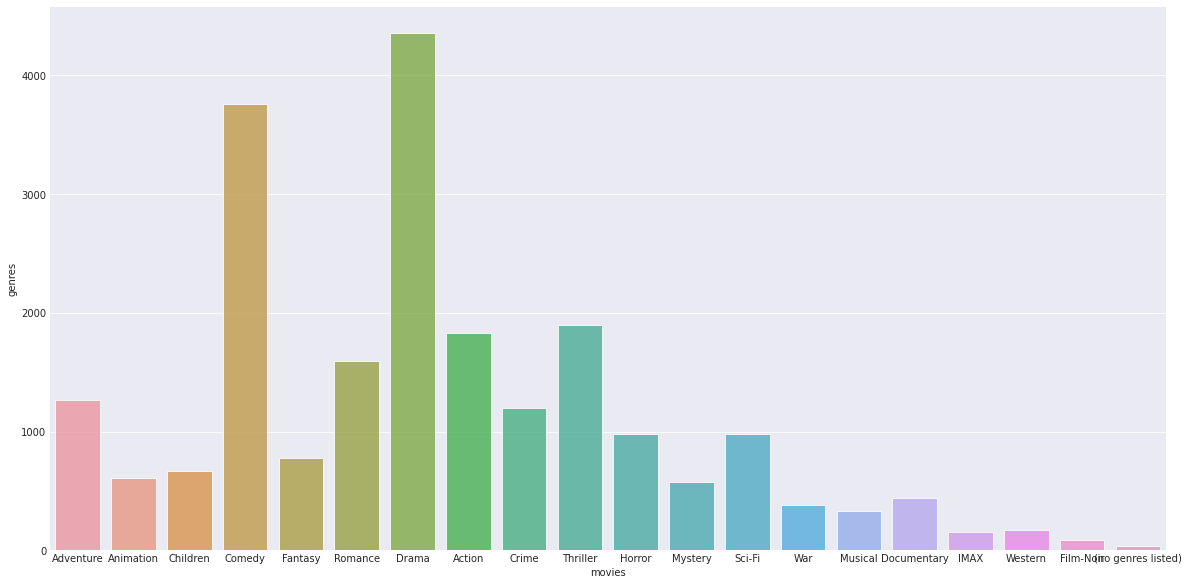

In [40]:
# genres graph
N, M =20, 10
fig, ax = plt.subplots(figsize=(N, M))

x = list(genre_dict.keys())
y = list(genre_dict.values())

sns.barplot(x, y, alpha=0.8)
plt.xlabel("movies")
plt.ylabel("genres")

plt.show()

`Output`

사람들은 `Drama`와 `Comedy` 관련 장르를 많이 시청했으나, `Western`과 `Film-Noir` 관련 장르는 많이 시청하지 않았다.
- `IMAX`는 영화 장르보다 영화 방식인 것 같아서 제외했다.

### 2. 사람들은 어떤 평점을 가장 많이 줬을까?
- 측정된 평점별 개수 확인하기

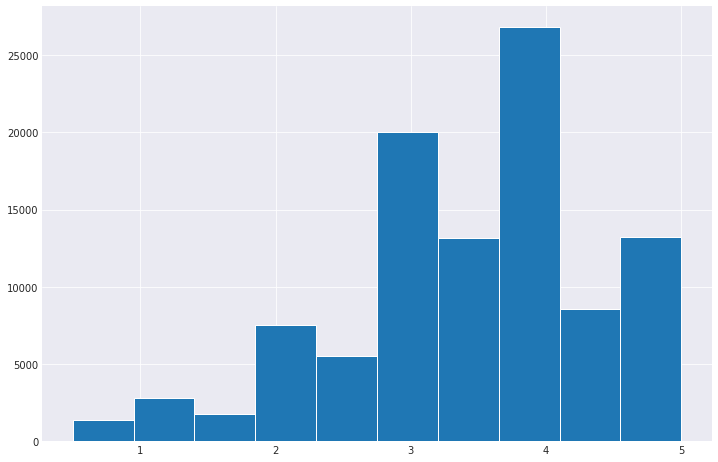

In [202]:
plt.figure(figsize=(12,8))

ratings.rating.hist()

`Output`

사람들은 4점을 가장 많이 줬고, 0.5점을 가장 적게 줬다.

### 3. 사람들은 어떤 영화를 가장 많이 봤을까?
- 영화별 평점 개수 확인하기

In [261]:
df_movies = pd.read_csv('/content/drive/MyDrive/ToBigs/RS/ml-latest-small 2/movies.csv', index_col='movieId', encoding='utf-8')

In [262]:
# 평점을 많이 받은 영화
ratings_count = ratings.groupby('movieId')['userId'].count()

ratings_count.head()

movieId
1    215
2    110
3     52
4      7
5     49
Name: userId, dtype: int64

In [263]:
df_ratings = pd.DataFrame({'ratings_count': ratings.groupby('movieId')['userId'].count(),})

df_ratings

,ratings_count
movieId,
1,215
2,110
3,52
4,7
5,49
...,...
193581,1
193583,1
193585,1


In [264]:
df_ratings['movie_title'] = df_ratings.apply(lambda x: df_movies['title'].loc[x.index])

df_ratings

,ratings_count,movie_title
movieId,,
1,215,Toy Story (1995)
2,110,Jumanji (1995)
3,52,Grumpier Old Men (1995)
4,7,Waiting to Exhale (1995)
5,49,Father of the Bride Part II (1995)
...,...,...
193581,1,Black Butler: Book of the Atlantic (2017)
193583,1,No Game No Life: Zero (2017)
193585,1,Flint (2017)


In [276]:
rating_sort = df_ratings.sort_values(by='ratings_count', ascending = False).reset_index()

rating_sort

,movieId,ratings_count,movie_title
0,356,329,Forrest Gump (1994)
1,318,317,"Shawshank Redemption, The (1994)"
2,296,307,Pulp Fiction (1994)
3,593,279,"Silence of the Lambs, The (1991)"
4,2571,278,"Matrix, The (1999)"
...,...,...,...
9719,4093,1,Cop (1988)
9720,4089,1,Born in East L.A. (1987)
9721,58351,1,City of Men (Cidade dos Homens) (2007)
9722,4083,1,Best Seller (1987)


In [280]:
# 막대 그래프
sort = rating_sort.loc[:20]

px.bar(sort, y = 'movie_title', x='ratings_count', color = 'movie_title', title = "Top selling product families")

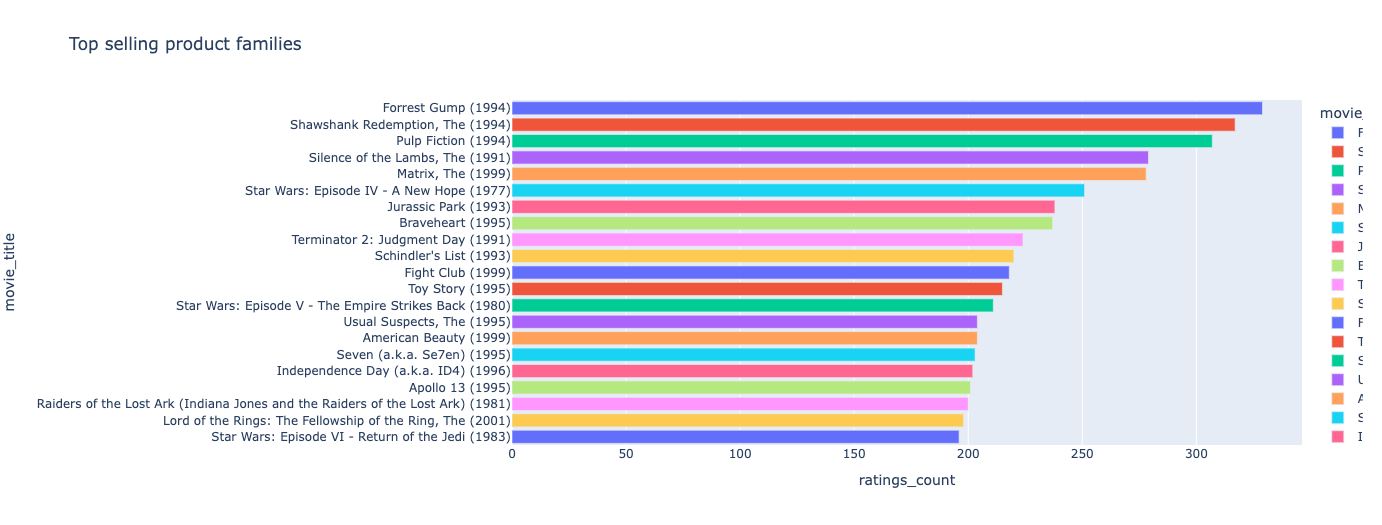

(bar chart가 보이지 않아, 따로 사진을 첨부했습니다.)

`Output`

사람들은 `Forrest Gump`, `The Shawshank Redemption` , `Pulp Fiction` 순으로 가장 평점을 많이 남겼다. 즉 이 순서대로 사람들이 가장 많이 시청했음을 알 수 있다.

### 4. 장르별 상관관계가 있을까?
- 장르별 상관관계 확인하기

In [236]:
df_genres.corr()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
(no genres listed),1.000000,-0.028442,-0.022840,-0.015309,-0.016005,-0.046878,-0.022171,-0.012871,-0.053277,-0.017447,-0.005618,-0.019769,-0.007599,-0.011151,-0.014794,-0.026195,-0.019792,-0.029073,-0.011956,-0.007816
Action,-0.028442,1.000000,0.291949,0.029659,-0.049652,-0.148968,0.154471,-0.099463,-0.152964,0.059931,-0.031649,-0.035443,0.131864,-0.083331,-0.028515,-0.146670,0.233475,0.199042,0.076289,0.021600
Adventure,-0.022840,0.291949,1.000000,0.211472,0.273931,-0.055215,-0.085988,-0.075111,-0.156327,0.262511,-0.030140,-0.098423,0.143982,-0.005544,-0.048427,-0.072584,0.181797,-0.035942,0.010195,0.036136
Animation,-0.015309,0.029659,0.211472,1.000000,0.437376,0.029079,-0.069847,-0.050144,-0.160504,0.196895,-0.015555,-0.062464,0.080744,0.111804,-0.030477,-0.061882,0.064093,-0.107822,-0.036990,-0.024378
Children,-0.016005,-0.049652,0.273931,0.437376,1.000000,0.088701,-0.086442,-0.056859,-0.160742,0.234117,-0.025673,-0.083569,0.062011,0.137072,-0.036449,-0.070189,-0.011910,-0.127716,-0.048341,-0.016890
Comedy,-0.046878,-0.148968,-0.055215,0.029079,0.088701,1.000000,-0.075282,-0.131657,-0.283472,-0.005708,-0.070710,-0.133382,-0.056627,0.045466,-0.127209,0.153088,-0.132400,-0.286289,-0.095919,-0.039622
Crime,-0.022171,0.154471,-0.085988,-0.069847,-0.086442,-0.075282,1.000000,-0.073955,0.063005,-0.086254,0.137141,-0.063805,-0.020892,-0.056850,0.124138,-0.097444,-0.095166,0.265196,-0.059585,-0.022997
Documentary,-0.012871,-0.099463,-0.075111,-0.050144,-0.056859,-0.131657,-0.073955,1.000000,-0.173925,-0.060473,-0.020645,-0.069364,0.003381,-0.005664,-0.050168,-0.093597,-0.072736,-0.104346,-0.013378,-0.024915
Drama,-0.053277,-0.152964,-0.156327,-0.160504,-0.160742,-0.283472,0.063005,-0.173925,1.000000,-0.106337,0.024256,-0.187391,-0.063293,-0.038022,0.027635,0.122454,-0.158325,-0.008267,0.135067,-0.025060
Fantasy,-0.017447,0.059931,0.262511,0.196895,0.234117,-0.005708,-0.086254,-0.060473,-0.106337,1.000000,-0.023962,0.012336,0.102962,0.050524,0.014768,-0.000635,0.046094,-0.057807,-0.043959,-0.021441


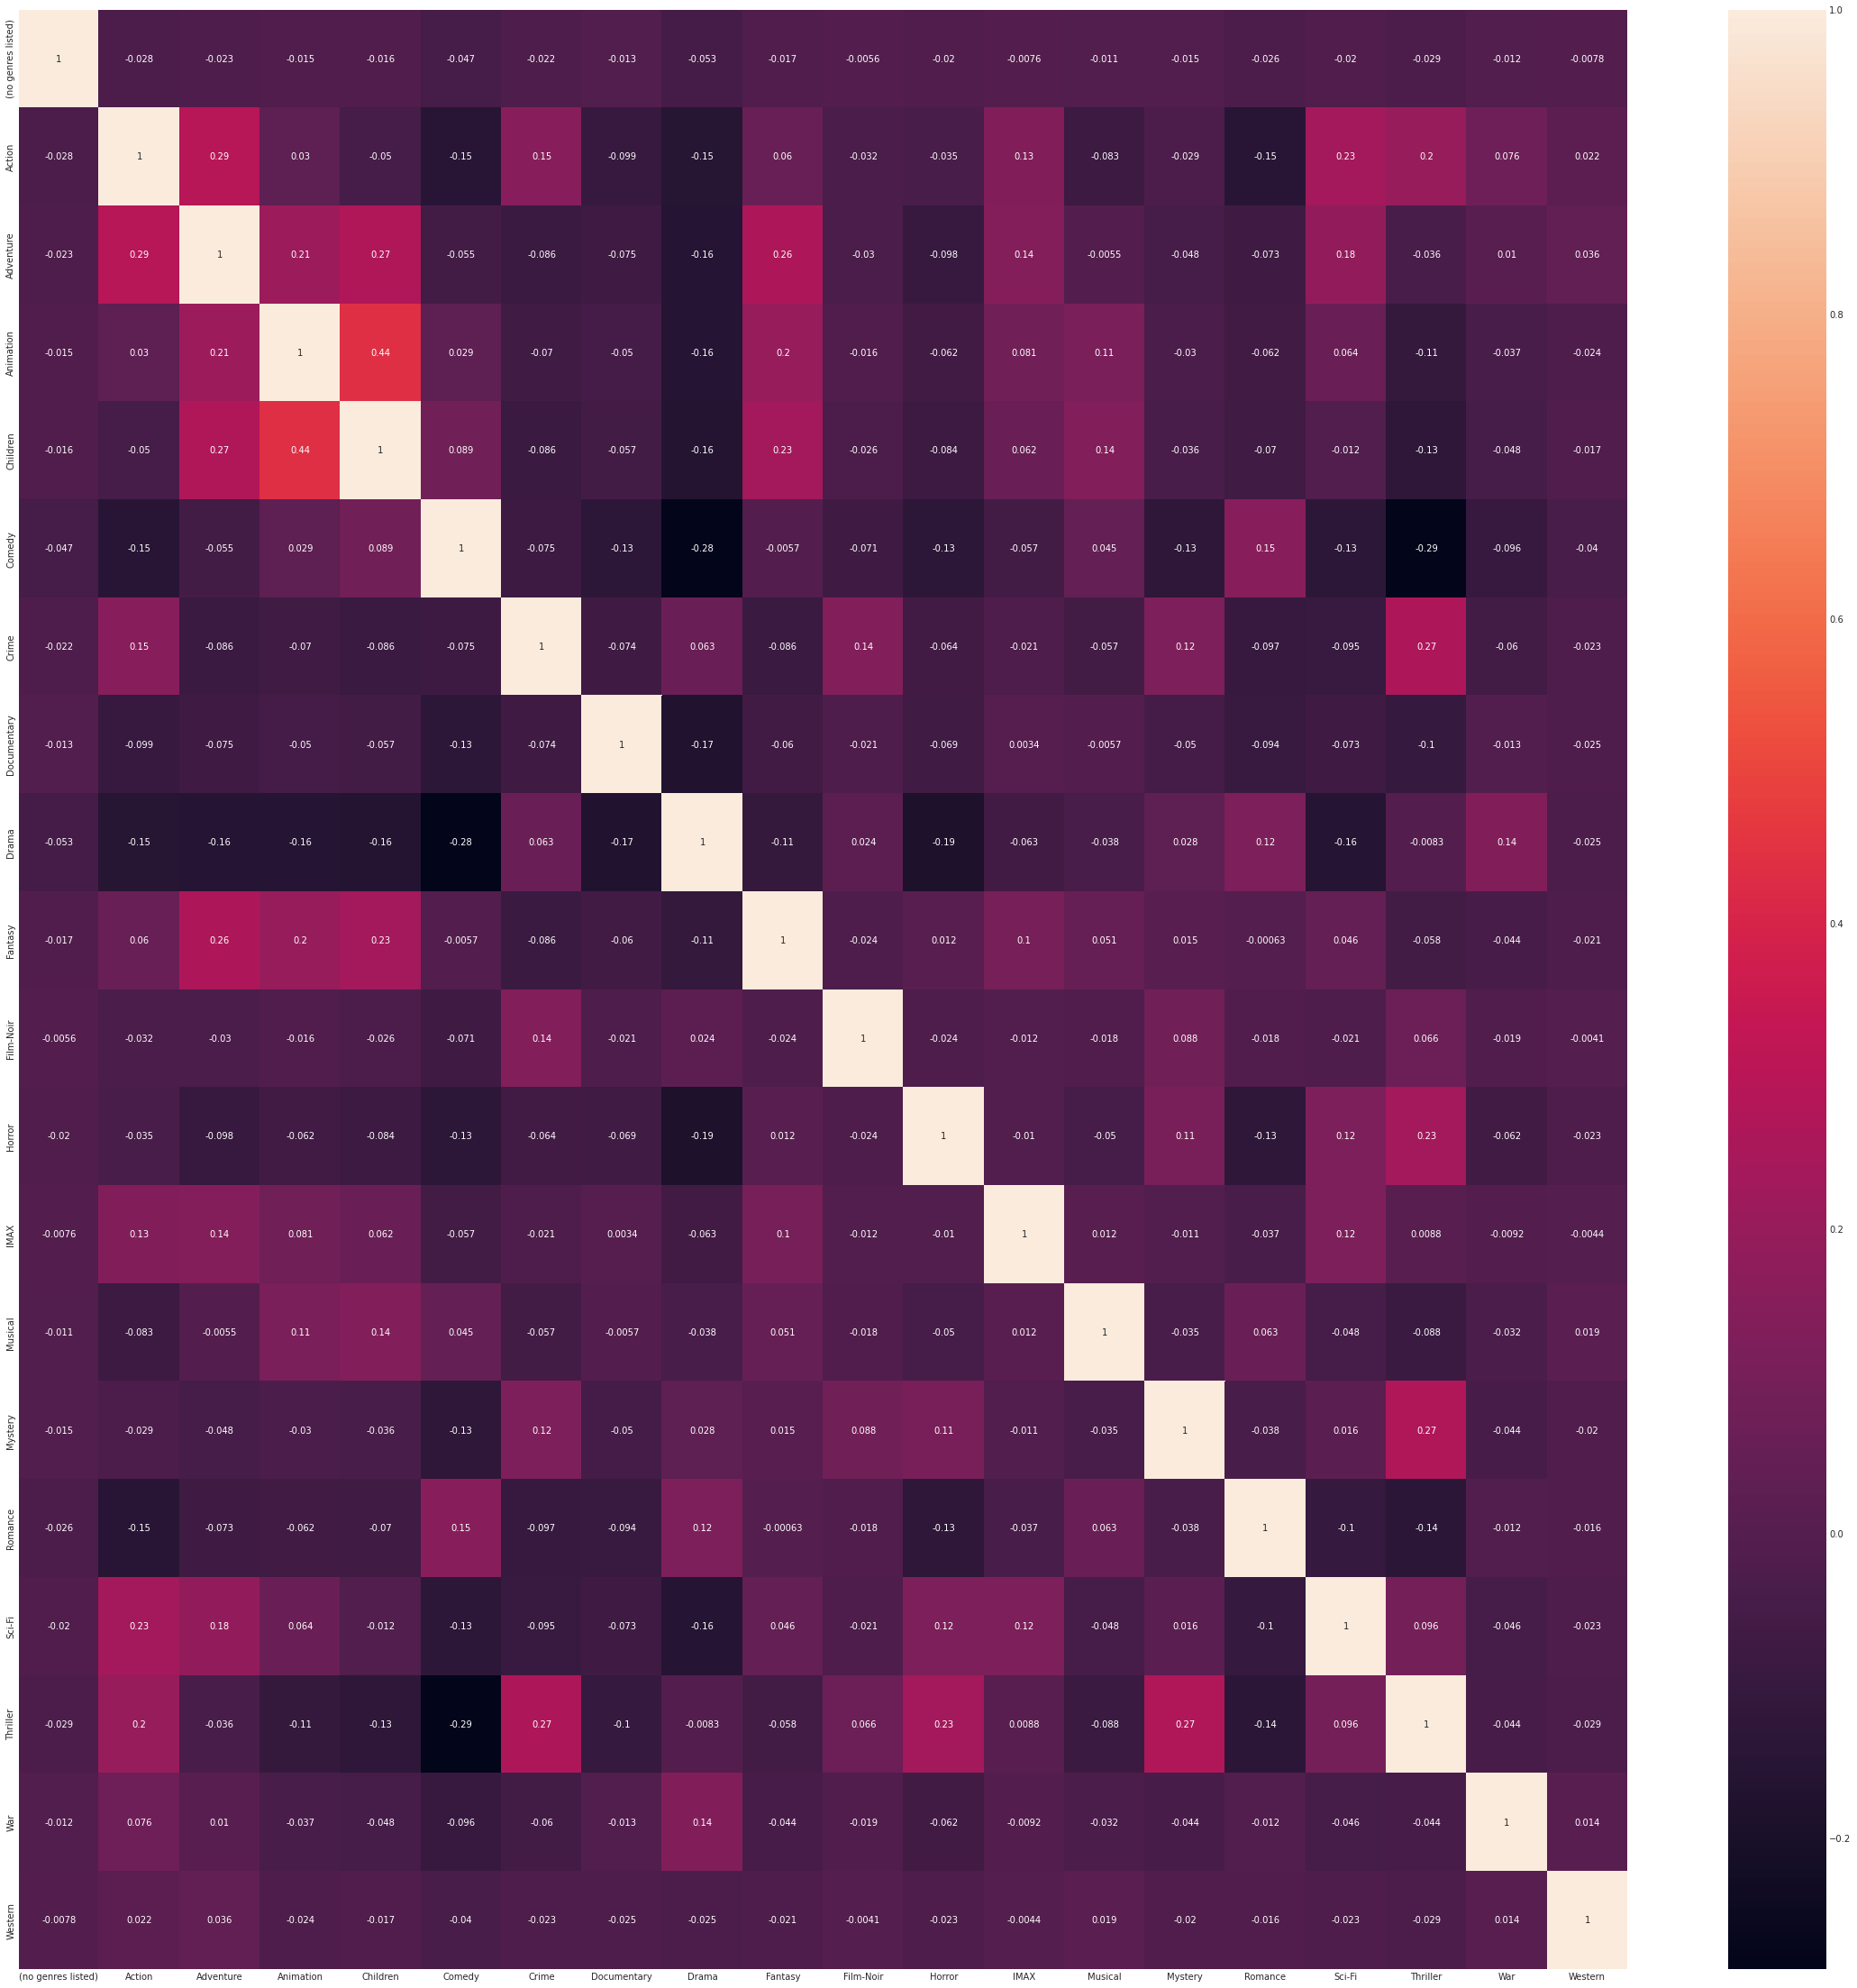

In [237]:
plt.figure(figsize=(40,40))
sns.heatmap(df_genres.corr(), annot=True)

`Output`

장르별 상관관계가 높지는 않다.

### 5. 시청자 수가 많은 장르일수록 평점이 높을까?
- 각 장르별 평균 평점 비교하기

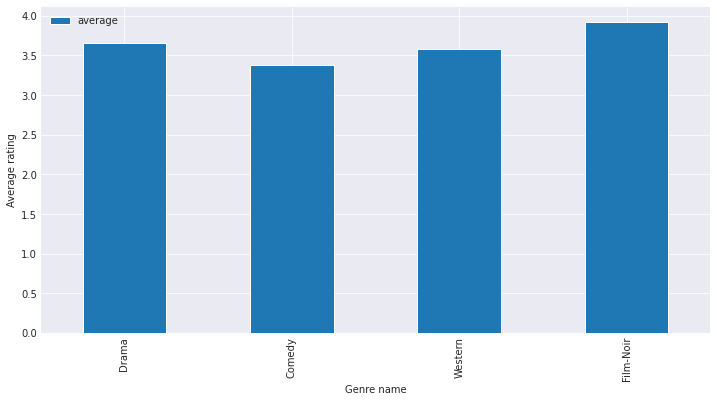

In [208]:
avg_genre.plot(kind='bar',y=['average'], figsize=(12, 6), xlabel="Genre name", ylabel="Average rating")

`Output`

사람들이 많이 시청한 `Drama`와 `Comedy` 관련 장르의 평균 평점이 `Western`과 `Film-Noir` 관련 장르의 평균 평점보다 비슷하거나 낮으므로 장르 시청자 수가 많다고하여 평점이 높지는 않다. 즉, 장르 시청자 수가 많을수록 장르 선호도가 높다고 판단할 수는 없다.
- 오히려 시청자 수가 적은 `Film-Noir` 장르에 매니아층이 몰려 평점이 매우 높은 것을 알 수 있다.

### 6. 시청자 수가 많은 영화일수록 평점이 높을까?
- 각 영화별 평균 평점 비교하기

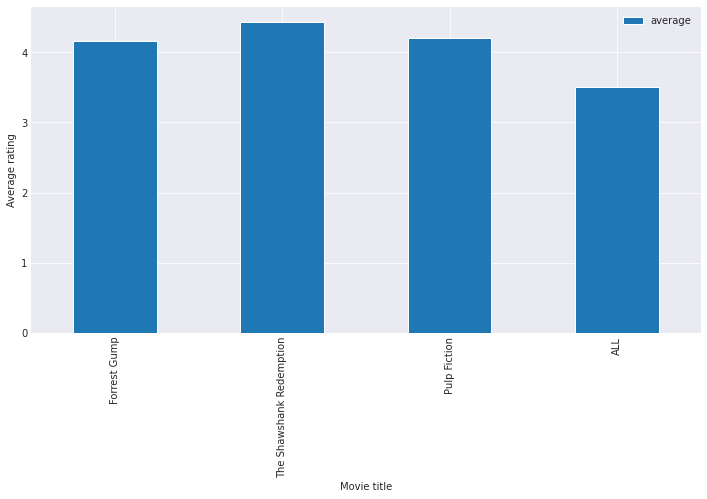

In [289]:
avg_title.plot(kind='bar',y=['average'], figsize=(12, 6), xlabel="Movie title", ylabel="Average rating")

`Output`

시청자 수가 가장 많았던 `Forrest Gump`, `The Shawshank Redemption` , `Pulp Fiction`의 평균 평점이 전체 평균 평점보다 현저히 높은 것으로 보아, 시청자 수가 많은 영화일수록 비교적 평점이 높다는 것을 알 수 있다.
- 장르와 평점은 관계가 없지만, 시청자 수와 평점 간의 관계가 있음을 알 수 있었다.

# Modeling & Evaluation

## Memory based CF
- KNN

1. 데이터 준비하기

In [120]:
# csr matrix
from scipy.sparse import csr_matrix

csr_data = csr_matrix(df_mr.values)
df_mr.reset_index(inplace=True)

csr_data

<2121x335 sparse matrix of type '<class 'numpy.float64'>'
	with 72787 stored elements in Compressed Sparse Row format>

In [128]:
piv3 = df2.pivot_table('rating', index = 'userId', columns = 'movieId')

piv3

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
piv3 = piv3.fillna(0)

piv3

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2. 코사인 유사도 구하기

In [130]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine = pd.DataFrame(cosine_similarity(piv3))

cosine

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,1.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,1.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,1.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,1.000000,0.053225


In [132]:
cosine.index = piv3.index
cosine.columns = piv3.index

cosine

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,1.000000,0.153063,0.262558,0.069622,0.201104
607,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,1.000000,0.283081,0.149190,0.139114
608,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,1.000000,0.121993,0.322055


3. KNN 가져오기

In [44]:
# KNN
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

### User based CF

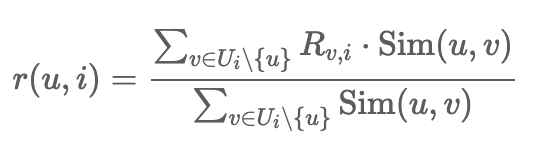

In [138]:
def user_based(userId):

    Id = userId
    idx = cosine[Id].sort_values(ascending = False)[1:10].index.values
    viewed_list = df2[df2['userId']==Id]['movieId'].values
    new_movie = []

    for i in idx:
        other_viewed_list = df2[df2['userId']==i].sort_values(by = 'rating', ascending = False)['movieId'].values
        for j in other_viewed_list:
            if j not in viewed_list:
                new_movie.append(j)
    
    for k in range(len(new_movie)):
        if k == 0 :
            recommend = movies[movies['movieId']==new_movie[k]]
        else :
            recommend = pd.concat([recommend, movies[movies['movieId']==new_movie[k]]])

    result = recommend[:10]
    
    return result

In [140]:
user_based(434)

,movieId,title,genres
6276,47610,"Illusionist, The (2006)",Drama|Fantasy|Mystery|Romance
413,475,In the Name of the Father (1993),Drama
922,1221,"Godfather: Part II, The (1974)",Crime|Drama
1243,1653,Gattaca (1997),Drama|Sci-Fi|Thriller
6170,44665,Lucky Number Slevin (2006),Crime|Drama|Mystery
5110,8132,Gladiator (1992),Action|Drama
2462,3275,"Boondock Saints, The (2000)",Action|Crime|Drama|Thriller
4118,5903,Equilibrium (2002),Action|Sci-Fi|Thriller
6557,54997,3:10 to Yuma (2007),Action|Crime|Drama|Western
6534,54286,"Bourne Ultimatum, The (2007)",Action|Crime|Thriller


`Output`

User based recommend system 결과, `User 434`에게 추천된 10개의 movie list는 다음과 같다.

### Item based CF

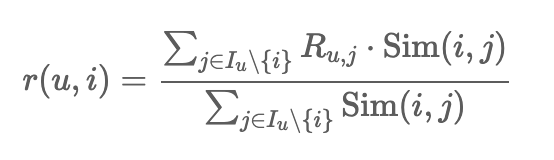

In [51]:
def item_based(movie_name):
    
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)] # Fint movie name
    
    if len(movie_list):
        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = df_mr[df_mr['movieId'] == movie_idx].index[0]
        
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = df_mr.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Correlation':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    
    else:
        return "No movies found. Please check your input"

In [73]:
# recommend result
item_based('Jurassic Park')

,Title,Correlation
1,Aladdin (1992),0.329313
2,"Fugitive, The (1993)",0.328515
3,Batman (1989),0.327701
4,Speed (1994),0.313140
5,Mission: Impossible (1996),0.308919
6,Toy Story (1995),0.306580
7,Braveheart (1995),0.298873
8,Forrest Gump (1994),0.266877
9,Independence Day (a.k.a. ID4) (1996),0.251815
10,Terminator 2: Judgment Day (1991),0.249738


`Output`

Item based recommend system 결과, `Jurassic Park`와 가장 연관이 깊은 영화는 `Aladdin`다.

## Model based CF


### Clustering-based Algorithm
- KNN


0. 세팅하기

In [63]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 9.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633971 sha256=5d4064ba19e8ad82d74032506c0db73c779b3936d0e6726d6e64eef4dba821cd
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [149]:
# settings
import surprise

from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
from surprise import Reader
from surprise import SVD
from surprise.dataset import DatasetAutoFolds

1. 데이터 준비하기

In [152]:
# load data
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [153]:
# split data
trainset, testset = train_test_split(data, test_size=0.2, random_state=0)

trainset

2. 사용자의 평점 예측하기
- `User 434`

In [154]:
user = str(434)
item = str(77)

In [146]:
# SVD
algo = SVD(n_factors=50, random_state=0)

algo.fit(trainset)

In [155]:
# predict ratings
pred = algo.predict(user, item, verbose=True)

user: 434        item: 77         r_ui = None   est = 3.50   {'was_impossible': False}


`Output`

`User 434`가 `movieID 77`에 대한 평점이 없으므로, 예상 평점을 3.50으로 예측했다.

3. 해당 User가 보지 않은 영화 개수 구하기

In [159]:
def get_unseen_surprise(ratings, movies, userId):
    seen_movies = ratings[ratings['userId']== userId]['movieId'].tolist()

    total_movies = movies['movieId'].tolist()

    unseen_movies = [ movie for movie in total_movies if movie not in seen_movies]

    total_movie_cnt = len(total_movies)
    seen_cnt = len(seen_movies)
    unseen_cnt = len(unseen_movies)
    
    print(f"전체 영화 개수: {total_movie_cnt}, 평점을 매긴 영화 개수: {seen_cnt}, 추천 대상 영화 개수: {unseen_cnt}")
    
    return unseen_movies

In [160]:
unseen_movies = get_unseen_surprise(ratings, movies, 434)

전체 영화 개수: 9742, 평점을 매긴 영화 개수: 233, 추천 대상 영화 개수: 9509


`Output`

`User 434`는 총 233개의 영화를 평가했고, 나머지 9509개의 영화 중에서 추천할 수 있다.

4. Surprise recommend model

In [167]:
def surprise(algo, userId, unseen_movies, top_n=10):
  
    predictions = []    
    for movieId in unseen_movies:
        predictions.append(algo.predict(str(userId), str(movieId)))

    def sortkey_est(pred):
        return pred.est

    predictions.sort(key=sortkey_est, reverse=True) 

    top_predictions = predictions[:top_n]

    print(f"Top-{top_n} Recommend Movies")
    
    for pred in top_predictions:
        
        movie_id = int(pred.iid)
        movie_title = movies[movies["movieId"] == movie_id]["title"].tolist()
        movie_rating = pred.est

        print(f"{movie_title}: {movie_rating:.2f}")

5. 추천 결과 출력하기

In [168]:
surprise(algo, 434, unseen_movies, top_n=10)

Top-10 Recommend Movies
['Grumpier Old Men (1995)']: 3.50
['Waiting to Exhale (1995)']: 3.50
['Father of the Bride Part II (1995)']: 3.50
['Sabrina (1995)']: 3.50
['Tom and Huck (1995)']: 3.50
['Sudden Death (1995)']: 3.50
['American President, The (1995)']: 3.50
['Dracula: Dead and Loving It (1995)']: 3.50
['Balto (1995)']: 3.50
['Nixon (1995)']: 3.50


`Output`

Surprise recommend model 결과, `User 434`에게 추천된 10개의 movie list는 다음과 같다.

6. 성능 평가하기

In [162]:
predictions = algo.test(testset)

In [163]:
# evaluation
accuracy.rmse(predictions)

RMSE: 0.8669


0.8668986463958782

### Deep Learning
- Stacked Autoencoder



In [87]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'GPU device name: {torch.cuda.get_device_name()}')

GPU device name: Tesla T4


1. 데이터 준비하기

In [95]:
# movieId 따로 뽑기
nb_movies = ratings['movieId'].nunique()

nb_movies

9724

In [98]:
# userId 따로 뽑기
nb_users = ratings['userId'].nunique()

nb_users

610

In [84]:
# creating data 1
ratings_matrix = ratings.pivot_table(index=['userId'], columns=['movieId'], values='rating').reset_index(drop=True)
ratings_matrix.fillna(0, inplace=True)

ratings_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
# creating data 2
data_matrix = np.array(ratings_matrix)

print(data_matrix.shape)
print(data_matrix)

(610, 9724)
[[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]


In [88]:
data_matrix_torch = torch.FloatTensor(data_matrix).to(device)

2. Stacked Autoencoder model

In [96]:
# model
class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_movies, 50)
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 50)
        self.fc4 = nn.Linear(50, nb_movies)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def prediction(self, x):
        pred = self.forward(x)
        return pred.detach().numpy()
    
model = SAE().to(device)

criterion = nn.MSELoss() # evaluation

optimizer = optim.RMSprop(model.parameters(), lr=0.01, weight_decay=0.5)

In [97]:
# Model Summary
from torchsummary import summary

summary(model, (610, 9724))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 610, 50]         486,250
           Sigmoid-2              [-1, 610, 50]               0
            Linear-3              [-1, 610, 10]             510
           Sigmoid-4              [-1, 610, 10]               0
            Linear-5              [-1, 610, 50]             550
           Sigmoid-6              [-1, 610, 50]               0
            Linear-7            [-1, 610, 9724]         495,924
Total params: 983,234
Trainable params: 983,234
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 22.63
Forward/backward pass size (MB): 46.28
Params size (MB): 3.75
Estimated Total Size (MB): 72.66
----------------------------------------------------------------


3. 모델 훈련하기

In [99]:
from torch.autograd import Variable

In [100]:
# training model
nb_epoch = 100
save_train_loss = []
epoch_num = []

min_train_loss = 1000
forgive = 30
forgive_count = 0

model.train()
torch.backends.cudnn.benchmark = True
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    steps = 0
    for id_user in range(nb_users):
        input = Variable(data_matrix_torch[id_user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = model(input)
            target.require_grad = False
            output[target == 0] = 0
            loss = criterion(output, target)
            mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
            loss.backward()
            train_loss += np.sqrt((loss.data * mean_corrector).cpu())
            steps += 1
            optimizer.step()

    epoch_train_loss = (train_loss/steps).item()
    if epoch%10 == 0:
        print(f'epoch #{str(epoch)} loss: {epoch_train_loss:.5f}')

    
    if min_train_loss >= (train_loss/steps).item():
        min_train_loss = (train_loss/steps).item()
        forgive_count = 0
    elif min_train_loss < (train_loss/steps).item():
        forgive_count += 1
    
    save_train_loss.append(epoch_train_loss)
    epoch_num.append(epoch)

    if forgive_count > forgive:
        print('Early stopping initiated')
        print('-'*25)
        print(f'epoch #{str(epoch)} loss: {epoch_train_loss:.5f}')
        break

epoch #10 loss: 1.12937
epoch #20 loss: 1.02836
epoch #30 loss: 0.99141
epoch #40 loss: 0.97255
epoch #50 loss: 0.96164
epoch #60 loss: 0.95491
epoch #70 loss: 0.95068
epoch #80 loss: 0.94796
epoch #90 loss: 0.94619
epoch #100 loss: 0.94501


4. 추천 결과 출력하기

In [107]:
ind_matrix = np.zeros((nb_users, nb_movies))
ind_matrix = np.where(data_matrix == 0, 1, 0)

pred = np.multiply(data_matrix_pred_SAE, ind_matrix)ㅌ

temp = []
top10 = []

# 각 user당 top 10 movie list 만들기
for person in range(nb_users):
    flag = False
    for rating in reversed(range(1,6)):
        for idx in range(len(pred[0])):
            if pred[person][idx] == rating:
                temp.append(idx)
                if len(temp) == 10:
                    top10.append(temp)
                    temp = []
                    flag = True
                    break
        if flag:
            break

In [115]:
# recommend result
user_id = np.random.randint(1,643)
movie_recommend = movies[movies['movieId'].isin(top10[user_id-1])]
movie_recommend = movie_recommend.style.set_caption(f'Possible Top 10 Movies for User {user_id}')

movie_recommend

,movieId,title,genres
42,46,How to Make an American Quilt (1995),Drama|Romance
44,48,Pocahontas (1995),Animation|Children|Drama|Musical|Romance
78,87,Dunston Checks In (1996),Children|Comedy
95,107,Muppet Treasure Island (1996),Adventure|Children|Comedy|Musical
350,405,Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994),Action|Fantasy
502,583,Dear Diary (Caro Diario) (1994),Comedy|Drama
563,680,"Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965)",Drama|Mystery|Romance|Sci-Fi|Thriller
577,708,"Truth About Cats & Dogs, The (1996)",Comedy|Romance


`Output`

Stacked Autoencoder model 결과, 랜덤으로 뽑은 `User 434`에게 추천된 10개의 movie list는 다음과 같다. 앞서 User based recommend system 추천 결과와 많이 다르다는 것을 알 수 있다.

5. 성능 평가하기
- training loss graph

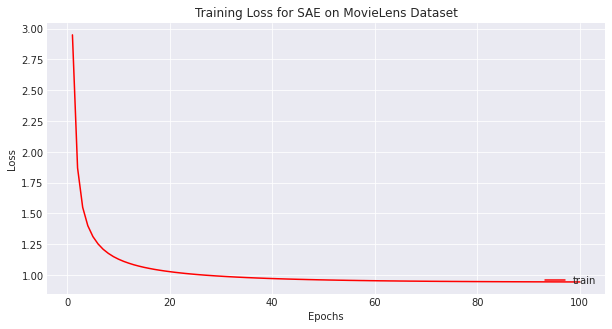

In [102]:
# training loss
plt.plot(epoch_num, save_train_loss, 'r', label='train')
plt.title('Training Loss for SAE on MovieLens Dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.rcParams['figure.figsize'] = [20, 10]

plt.show()

- RSME

In [103]:
# SAE prediction
predict_SAE = np.zeros((nb_users, nb_movies))

for id_user in range(nb_users):
    input = Variable(data_matrix_torch[id_user]).unsqueeze(0)
    predict_SAE[id_user] = model.cpu().prediction(input.cpu())

data_matrix_pred_SAE = np.where(data_matrix == 0, predict_SAE, data_matrix)

for i in range(data_matrix_pred_SAE.shape[0]):
    for j in range(data_matrix_pred_SAE.shape[1]):
        data_matrix_pred_SAE[i, j] = round(data_matrix_pred_SAE[i, j])

X_pred = np.zeros((nb_users, nb_movies))
for i in range(predict_SAE.shape[0]):
    for j in range(predict_SAE.shape[1]):
        X_pred[i, j] = round(predict_SAE[i, j])

In [104]:
# 원본 rating 
print("Original Rating Matrix: \n", data_matrix)

Original Rating Matrix: 
 [[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]


In [105]:
# Stacked Auto-Encoder 적용한 후 rating
print("Rating Matrix after Applying Stacked Auto-Encoder: \n", data_matrix_pred_SAE)

Rating Matrix after Applying Stacked Auto-Encoder: 
 [[4. 4. 4. ... 3. 3. 3.]
 [4. 4. 3. ... 3. 3. 3.]
 [4. 4. 3. ... 3. 3. 3.]
 ...
 [2. 2. 2. ... 3. 3. 3.]
 [3. 4. 3. ... 3. 3. 3.]
 [5. 4. 3. ... 3. 3. 3.]]


In [106]:
# RMSE
ind_matrix = np.zeros((nb_users, nb_movies))
ind_matrix = np.where(data_matrix != 0, 1, 0)

x = np.multiply(X_pred, ind_matrix)
RMSE_SAE = np.sqrt(np.mean((x - data_matrix)**2))
print("RMSE of SAE Model is %f." %RMSE_SAE)

RMSE of SAE Model is 0.122746.
